### Clasificación de imágenes de personas con mascarilla

#### Parte 3 con Tensores Y otros tipos especiales de datos

#### Usamos el dataset grande proporcionado (data)

#### Carga de Librerías

In [97]:
from keras.utils import image_dataset_from_directory


import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#Keras
import tensorflow as tf
import keras
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Input
from keras.models import Sequential, Model
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

#### Carga de los datos

In [98]:
#CARGA DE LOS DATOS (BIEN HECHA)
#Cargamos las imágenes sin dividir
BATCH_SIZE = 32 #quiere decir que tomará 32 imágenes por lote para entrenar o validar
IMG_SIZE = (128, 128) #las imágenes serán de 128 x 128

test_dir = r"../PracticaMascarillas2/data"



full_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    label_mode = 'binary'
)

#Convertimos el Dataset en array para poder dividir
labels = []
images = []

#Cargamos imágenes y etiquetas en listas (2 elementos dada la estructura)
for image_batch, label_batch in full_ds:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())
    
labels = np.concatenate(labels)
images = np.concatenate(images)

#Dividimos el conjunto de datos en train 80, validacion 10 y test 10
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

#Volver a convertir a datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

Found 7553 files belonging to 2 classes.


### PASO 3 NORMALIZACIÓN DE IMÁGENES

Ahora es importante normalizar los valores de la imagen a una escala de 0 a 1

Podemos usar **Rescaling** y por otro lado para prevenir el overfitting usaremos el **data augmentation**

In [99]:
#normalization = Rescaling(1./255)

data_augmentation = Sequential([
 RandomFlip("horizontal"), #Volteo horizontal
 RandomRotation(0.2), #Rotaciones 20% de 360º
 RandomZoom(0.1), #Zoom hasta 10%
 RandomTranslation(0.1, 0.1) #Desplaz. vertical y horizontal
])

#train_dataset = train_dataset.map(lambda x, y: (data_augmentation(normalization(x)), y))
#test_dataset = test_dataset.map(lambda x, y: (normalization(x), y))

#### 4.2 Construcción y compilación de la CNN básica con Keras

Además de las capas conocidas **Input** y **Dense** añadiremos estas nuevas:

- Conv2D -> Convolucional
- MaxPooling2D -> Para realizar pooling
- Flatten -> Aplanado antes de Dense

In [100]:
early_stopping = EarlyStopping(
 monitor='val_loss', # Métrica a controlar
 min_delta=0.001, # Mejora mínima significativa
 patience=5, # Esperar 10 épocas sin mejora antes de parar
 mode='min', # Monitorizar si la pérdida disminuye
 restore_best_weights=True # Restaurar los mejores pesos
)

model = keras.Sequential([
 Input(shape=(128, 128, 3)),
 data_augmentation,   
 Rescaling(1./255),

 Conv2D(32, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Conv2D(64, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Conv2D(128, (3, 3), activation='relu'),
 MaxPooling2D((2, 2)),

 Flatten(),
 Dense(256, activation='relu'),
 Dense(1, activation='sigmoid')  # Solo una neurona para clasificación binaria
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_18 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

El modelo consta de dos capas convolucionales con ReLu como función de activación, seguidas de capas de pooling y una capa completamente conectada (la clásica capa oculta de neuronas vista en la unidad anterior) para la clasificación

#### 4.3 Entrenamiento, evaluación y visualización de resultados

Una vez hecha la CNN deberemos entrenarla

In [101]:

#history = model.fit(
# train_dataset,
# validation_data=test_dataset,
# epochs=20,
# batch_size=32
#)
epochs = 30

history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size=BATCH_SIZE, callbacks=[early_stopping])



Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.7337 - loss: 0.5659 - val_accuracy: 0.8609 - val_loss: 0.3625
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.8490 - loss: 0.3586 - val_accuracy: 0.8649 - val_loss: 0.3087
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.8601 - loss: 0.3411 - val_accuracy: 0.8623 - val_loss: 0.2991
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.8673 - loss: 0.3201 - val_accuracy: 0.8715 - val_loss: 0.2877
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.8760 - loss: 0.3021 - val_accuracy: 0.8861 - val_loss: 0.2646
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.8792 - loss: 0.2913 - val_accuracy: 0.8980 - val_loss: 0.2293
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.8859 - loss: 0.2790 - val_accuracy: 0.8954 - val_loss: 0.2312
Epoch 8/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.8989 - loss: 0

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9497 - loss: 0.1252
Pérdida en test: 0.1449
Precisión en test: 0.9378


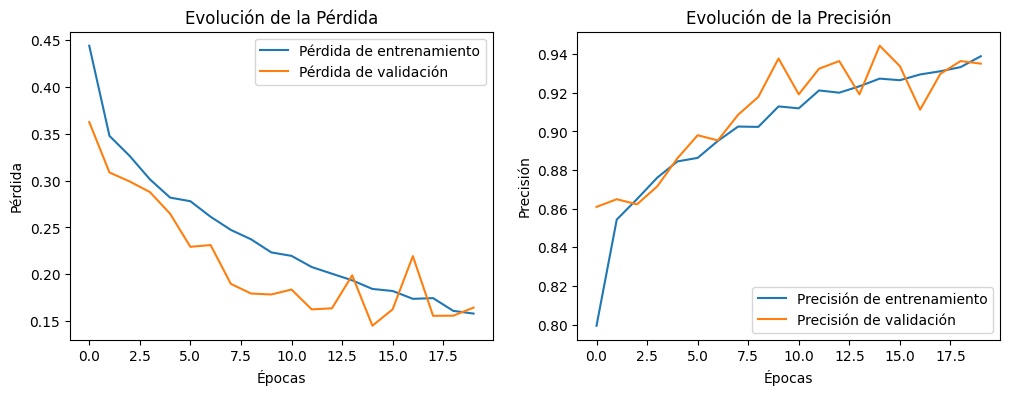

In [102]:
#Evaluación del modelo en el conjunto de test
loss, accuracy = model.evaluate(test_dataset)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")
#Visualización de la evolución del entrenamiento
import matplotlib.pyplot as plt

epochs = len(history.history['loss'])  #Faltaba (obtenemos el número real de épocas entrenadas)

#Extraer los valores del historial
epochs_range = range(epochs)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')
plt.show()

Como vemos los resultados son buenos

#### 4.4 Uso del modelo en predicciones

Una vez ha sido entrenado el modelo podemos utilizarlo para hacer predicciones con nuevas imágenes

Tenemos que cargar la imagen, procesarla igual que las imágenes del entrenamiento y pasarla al modelo

In [103]:
# Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(val_dataset)

# Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

# Verificar las formas
# print(f"test_Y shape: {test_dataset.shape}")  # Usar labels en test_dataset
print(f"predicted_classes shape: {predicted_classes.shape}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
predicted_classes shape: (755,)


In [104]:
#ESTA MAL! HAY QUE COMPROBAR EL VAL_DATASET (EL TEST_DATASET NO)
#from sklearn.metrics import classification_report

# Obtener etiquetas reales y predicciones del modelo
#true_labels = []
#pred_labels = []

#for images, labels in test_dataset:
#    predictions = model.predict(images)
#    predicted_classes = (predictions > 0.5).astype(int)

#    true_labels.extend(labels.numpy())
#    pred_labels.extend(predicted_classes)

# Generar el reporte de clasificación
#report = classification_report(true_labels, pred_labels, target_names=["Sin mascarilla", "Con mascarilla"])
#print(report)


In [ ]:
target_names = ["with_mask", "without_mask"]

#Hacer las predicciones sobre el conjunto de prueba
predictions = model.predict(val_dataset)

#Convertir las predicciones en clases binarias
predicted_classes = (predictions > 0.5).astype(np.float32).flatten()

#Obtener las etiquetas reales
true_labels = []
for _, labels in val_dataset:
    true_labels.append(labels)
true_labels = np.concatenate(true_labels)  # Convertir a array de NumPy

#Verificar las formas
print(f"true_labels shape: {true_labels.shape}")
print(f"predicted_classes shape: {predicted_classes.shape}")

#Mostrar el classification_report
print(classification_report(true_labels, predicted_classes, target_names=target_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
true_labels shape: (755, 1)
predicted_classes shape: (755,)
              precision    recall  f1-score   support

   with_mask       0.94      0.95      0.95       386
without_mask       0.95      0.94      0.94       369

    accuracy                           0.94       755
   macro avg       0.94      0.94      0.94       755
weighted avg       0.94      0.94      0.94       755



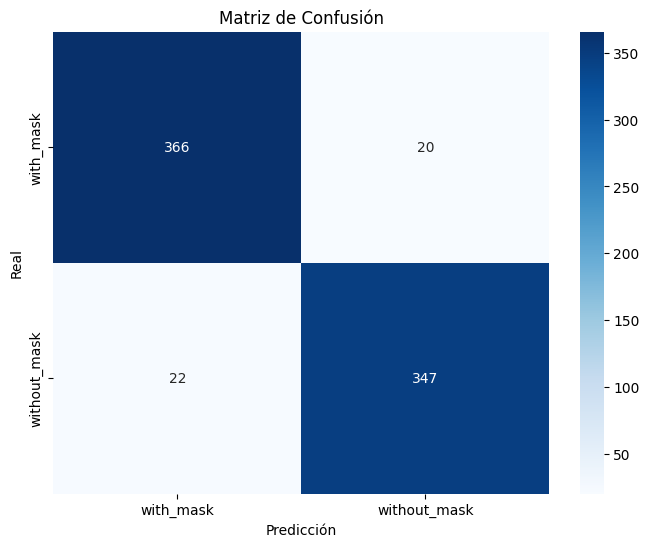

In [ ]:
#Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

#Etiquetas correctas para las 10 clases
target_names = ["with_mask", "without_mask"]

#Mostrar matriz de confusión con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [107]:
for images, labels in train_dataset.take(1):  # Tomamos un batch
    print(f"Forma de las imágenes: {images.shape}")
    print(f"Forma de las etiquetas: {labels.shape}")


Forma de las imágenes: (32, 128, 128, 3)
Forma de las etiquetas: (32, 1)
